<h2>📁 Introduction: Data Preparation</h2>

<p>
This notebook focuses on the essential data preparation steps for our Deep Learning project as part of the 2024/25 Master’s in Data Science program. Our task is to develop a deep-learning model capable of classifying rare species into their correct <strong>family</strong>, using image data curated from the <a href="https://eol.org/" target="_blank">Encyclopedia of Life (EOL)</a> and structured metadata based on the <em>BioCLIP</em> dataset.
</p>

<p>
Before training our model, it is critical to organize and preprocess the data properly. The dataset includes:
</p>

<ul>
  <li>A CSV file containing image file paths and corresponding labels (e.g., Kingdom, Phylum, Family)</li>
  <li>Image files categorized into various species</li>
</ul>

<p>
In this notebook, we:
</p>

<ol>
  <li>Load and inspect the metadata CSV</li>
  <li>Validate image paths and label consistency</li>
  <li>Visualization of a few basics like Family and Phylum for data understanding</li>
  <li>Split the data into training, validation, and test sets</li>
  <li>Apply preprocessing and augmentations (e.g., resizing (cut the image edged, where no animals are -> NOT done yet!), normalization)</li>
  <li>First simple model to test if basics work -> Test Accuracy: 0.1446 :'(</li>
</ol>

<p>
The goal is to ensure a clean and structured dataset pipeline that supports robust and reproducible model training, following the project guidelines and evaluation criteria.
</p>


# Imports

In [28]:
import sys
!{sys.executable} -m pip install pandas scikit-learn matplotlib


In [1]:
# python standard library imports
from typing import Self, Any
from pathlib import Path

In [2]:
from keras.utils import image_dataset_from_directory

In [3]:
# augmentation operations
from keras.layers import Rescaling, RandAugment

In [4]:
from matplotlib.image import imread

#from src.utils import show_image

----------------

In [5]:
import pandas as pd 
from PIL import Image # To open images and check thei validity
import os


import matplotlib.pyplot as plt # for visually checking images
import random

from sklearn.model_selection import train_test_split # for data split

from sklearn.model_selection import StratifiedShuffleSplit 

In [ ]:
metadata = pd.read_csv('../data/rare_species 1/metadata.csv')
metadata.head(10)

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...
5,dc48f2ce-4feb-4ef7-b2a2-c3c3f42bf19b,28657539,491832,animalia,arthropoda,formicidae,arthropoda_formicidae/28657539_491832_eol-full...
6,3d881320-8ba8-4580-a72c-0e7ab116b664,29548208,47043290,animalia,chordata,fringillidae,chordata_fringillidae/29548208_47043290_eol-fu...
7,7faca96a-54e6-4c80-b9e4-77ab126d904a,21232818,1033999,animalia,arthropoda,gomphidae,arthropoda_gomphidae/21232818_1033999_eol-full...
8,9f89ecab-aabd-41a4-b5b4-8ce106d85959,20315204,46561012,animalia,chordata,myliobatidae,chordata_myliobatidae/20315204_46561012_eol-fu...
9,b6ec7a70-c470-4ede-8930-05844e1efd2e,20124498,46570095,animalia,chordata,pleuronectidae,chordata_pleuronectidae/20124498_46570095_eol-...


# Validate image paths and label consistency

In [35]:
print(metadata.columns)

Index(['rare_species_id', 'eol_content_id', 'eol_page_id', 'kingdom', 'phylum',
       'family', 'file_path'],
      dtype='object')


In [36]:
total_images = len(metadata)
print(f"Total number of image files: {total_images}")

Total number of image files: 11983


Maybe check if file paths are correct? (not relly neccessery but seen at other groups)

## More data integrity checks

In [37]:
metadata.describe(include="O")

,rare_species_id,kingdom,phylum,family,file_path
count,11983,11983,11983,11983,11983
unique,11983,1,5,202,11983
top,75fd91cb-2881-41cd-88e6-de451e8b60e2,animalia,chordata,cercopithecidae,mollusca_unionidae/12853737_449393_eol-full-si...
freq,1,11983,9952,300,1


In [38]:
# Check for duplicate values
print("Number of duplicate rows:")
metadata.duplicated().sum()

Number of duplicate rows:


np.int64(0)

In [39]:
for column in metadata.select_dtypes(include="object").columns:
    if column == "rare_species_id":
        continue
    print(f"Value counts for column '{column}':")
    print(metadata[column].value_counts().head(10))  # Display top 10 most common values
    print("\n")

Value counts for column 'kingdom':
kingdom
animalia    11983
Name: count, dtype: int64


Value counts for column 'phylum':
phylum
chordata         9952
arthropoda        951
cnidaria          810
mollusca          210
echinodermata      60
Name: count, dtype: int64


Value counts for column 'family':
family
cercopithecidae    300
dactyloidae        300
formicidae         291
plethodontidae     270
carcharhinidae     270
salamandridae      270
bovidae            240
bucerotidae        210
acroporidae        210
anatidae           180
Name: count, dtype: int64


Value counts for column 'file_path':
file_path
mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg           1
chordata_rhyacotritonidae/8791267_1018900_eol-full-size-copy.jpg    1
chordata_equidae/29470476_129474_eol-full-size-copy.jpg             1
chordata_atelidae/21756124_323915_eol-full-size-copy.jpg            1
chordata_colubridae/8959497_1055211_eol-full-size-copy.jpg          1
chordata_hynobiidae/20900174_1048038

## Visualize the different Categories for better understanding 

In [40]:
phylum_counts.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Distribution of Phylum Categories', fontsize=16)
plt.xlabel('Phylum', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

NameError: name 'phylum_counts' is not defined

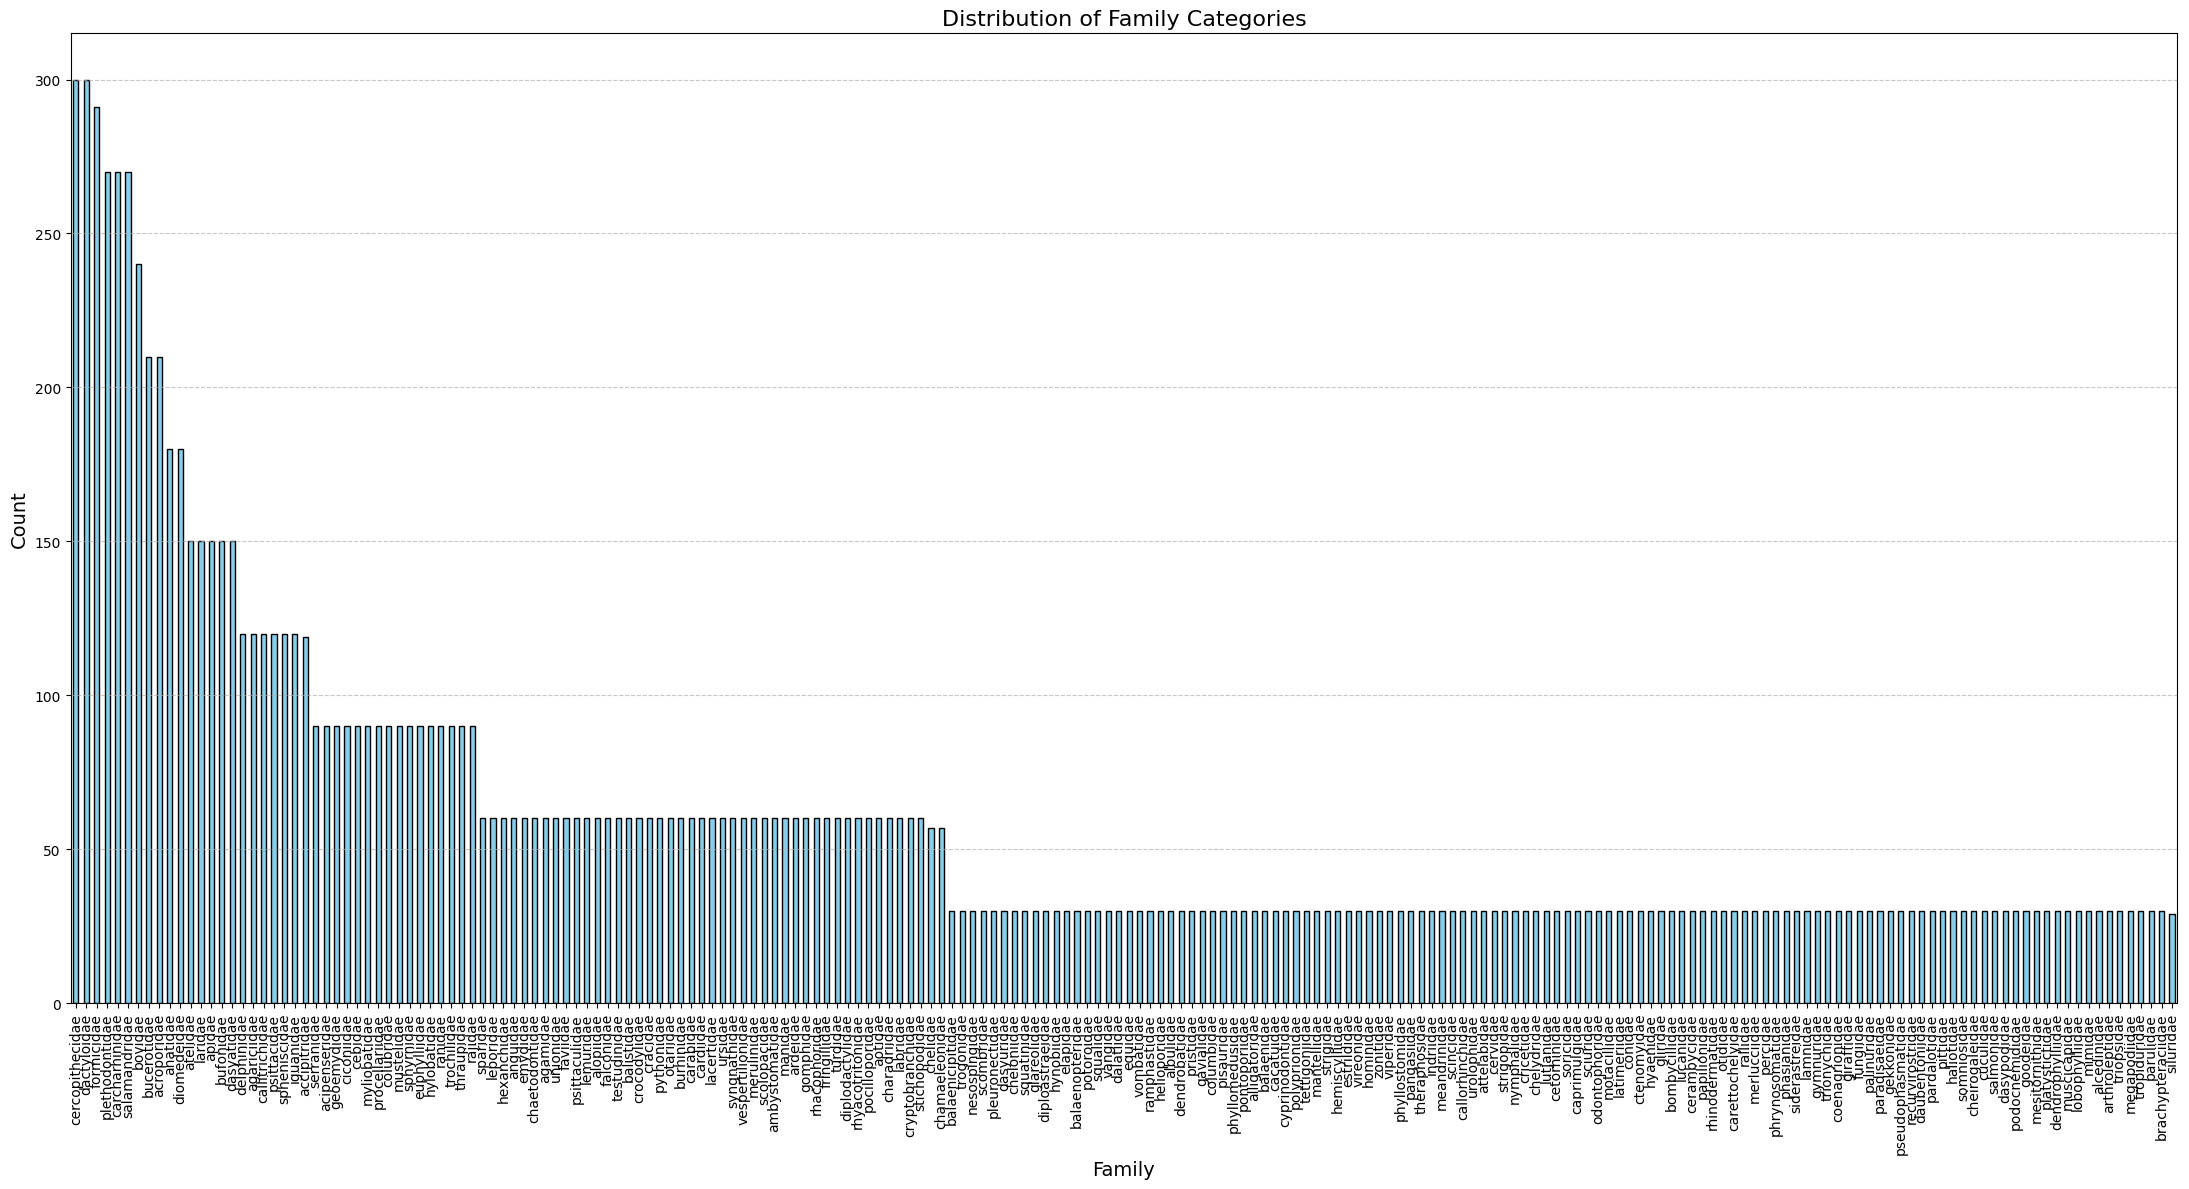

In [ ]:
family_counts = metadata['family'].value_counts()

family_counts.plot(kind='bar', figsize=(22, 12), color='skyblue', edgecolor='black')
plt.title('Distribution of Family Categories', fontsize=16)
plt.xlabel('Family', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

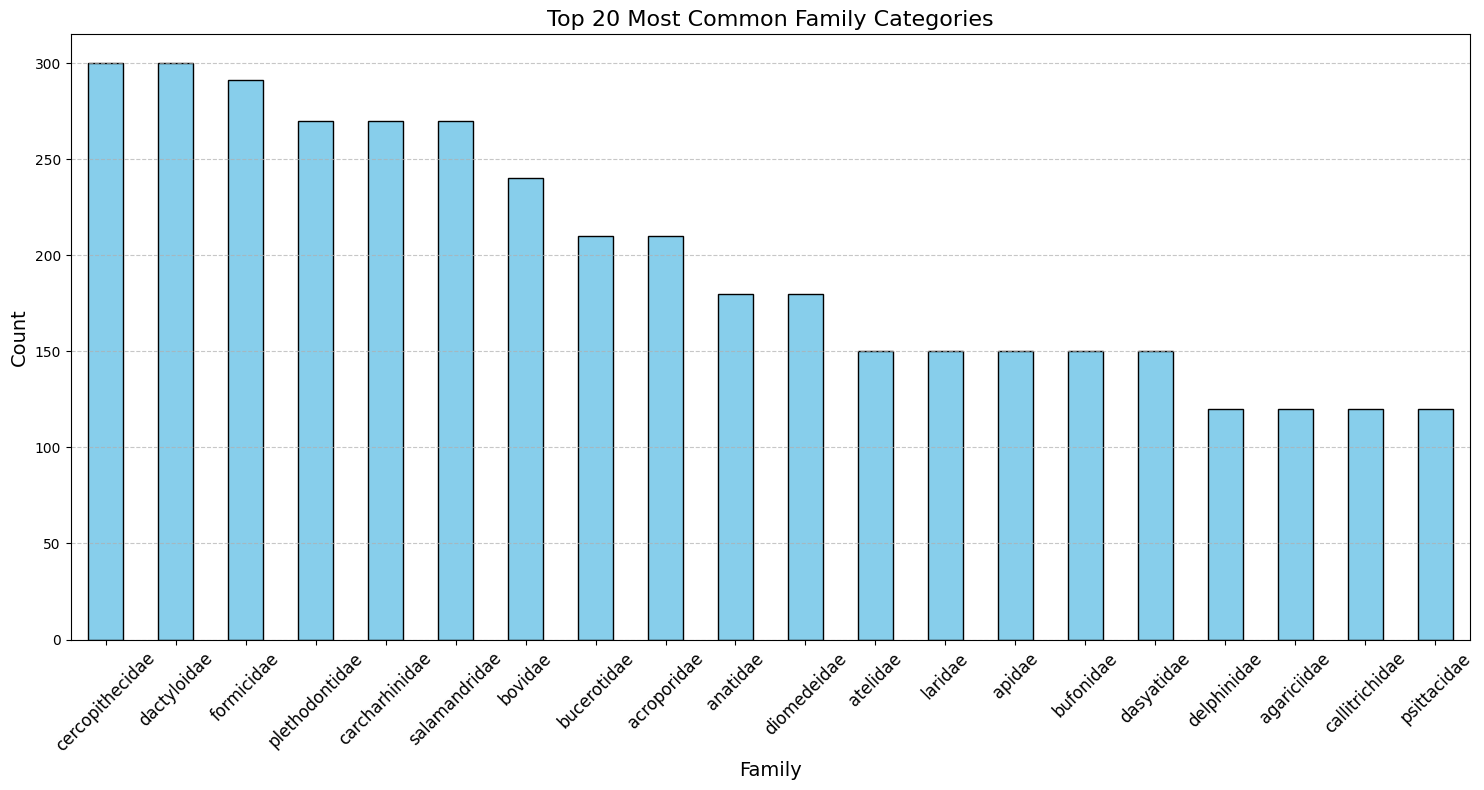

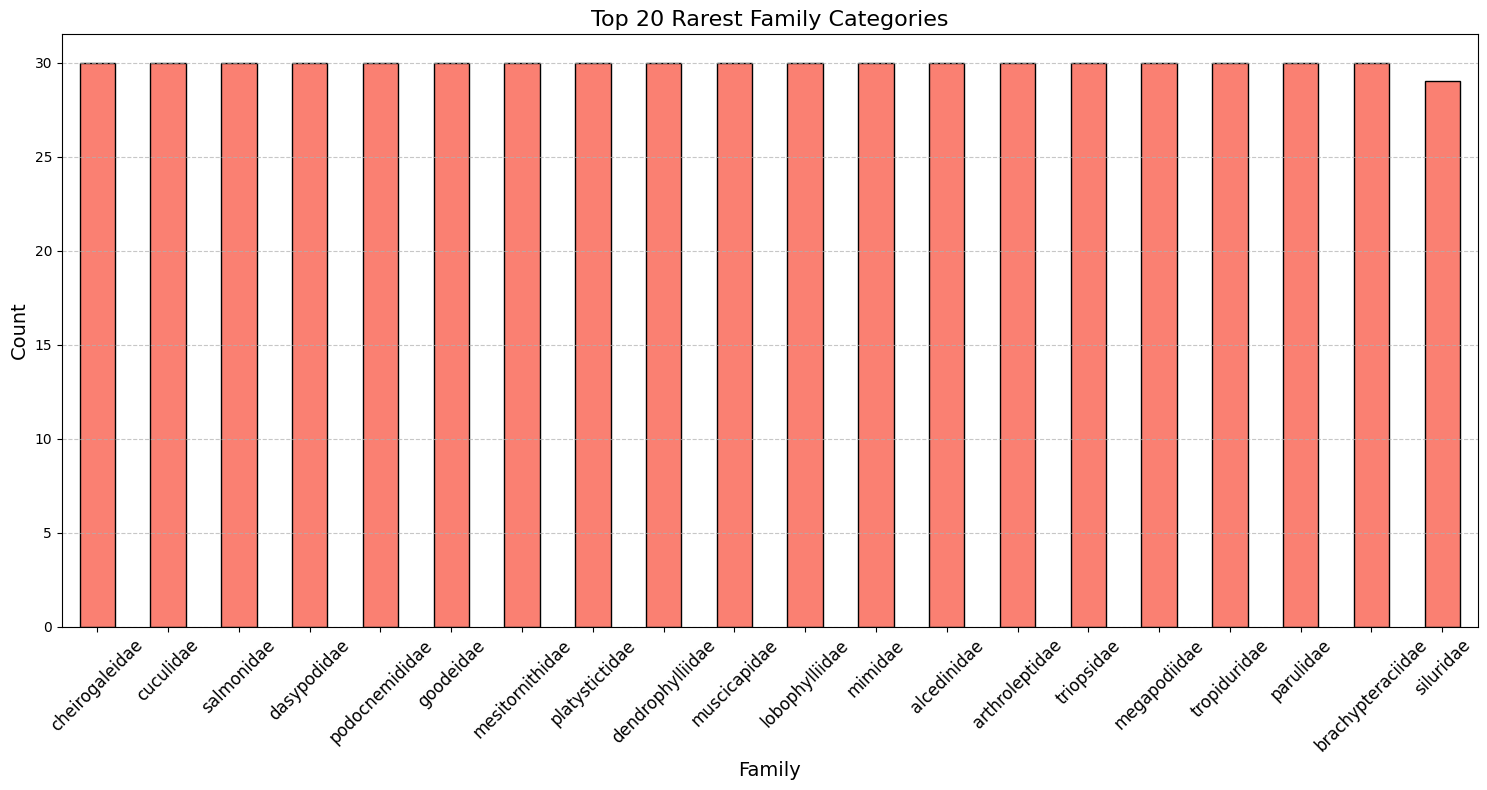

In [ ]:
# Top 20 most common families
top_20_common = family_counts.head(20)

# Top 20 rarest families
top_20_rare = family_counts.tail(20)

# Plot for most common families
plt.figure(figsize=(15, 8))
top_20_common.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 20 Most Common Family Categories', fontsize=16)
plt.xlabel('Family', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot for rarest families
plt.figure(figsize=(15, 8))
top_20_rare.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Top 20 Rarest Family Categories', fontsize=16)
plt.xlabel('Family', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

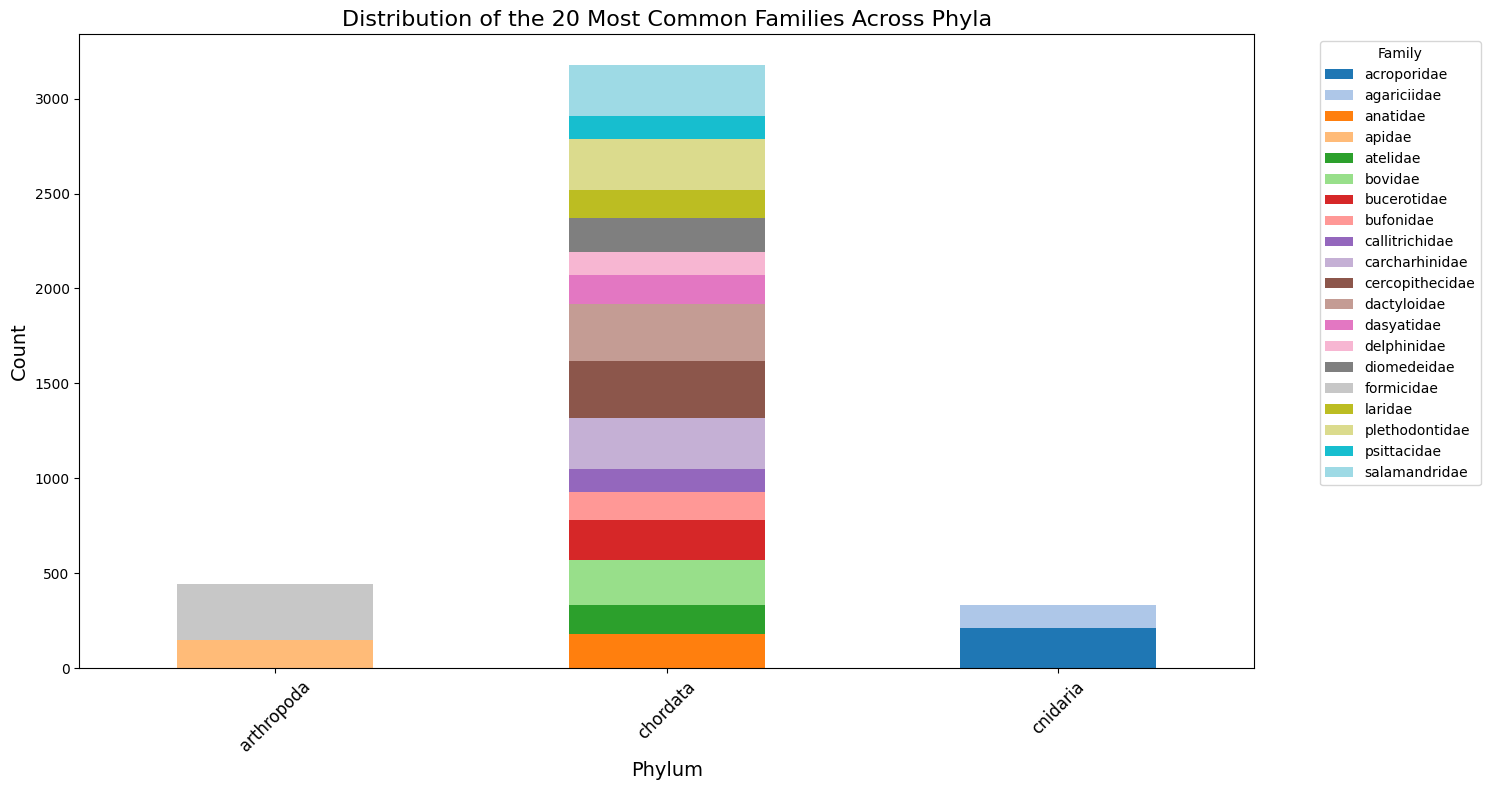

In [ ]:
# Filter the top 20 most common families
top_20_common_families = family_counts.head(20)

# Create a DataFrame for the top 20 families with their phylum
top_20_families_df = metadata[metadata['family'].isin(top_20_common_families.index)]

# Group by phylum and family, then count occurrences
phylum_family_distribution = top_20_families_df.groupby(['phylum', 'family']).size().unstack(fill_value=0)

# Plot the distribution
phylum_family_distribution.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='tab20')
plt.title('Distribution of the 20 Most Common Families Across Phyla', fontsize=16)
plt.xlabel('Phylum', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Family', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()
plt.show()

### check for missing image files

In [ ]:
from tqdm import tqdm

missing_images = []
image_base_path = '../data/rare_species 1/images'  # adjust if needed

for relative_path in tqdm(metadata['file_path']):
    full_path = os.path.join(image_base_path, relative_path)
    if not os.path.exists(full_path):
        missing_images.append(full_path)

print(f"Missing images: {len(missing_images)}")

100%|██████████| 11983/11983 [00:00<00:00, 579390.01it/s]

Missing images: 11983


In [7]:
num_classes = metadata['family'].nunique()
print(f"Number of unique classes (families): {num_classes}")

Number of unique classes (families): 202


### Create train/val/split (stratified)

In [ ]:
train_val_df, test_df = train_test_split(metadata, test_size=0.15, stratify=metadata['family'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.15, stratify=train_val_df['family'], random_state=42)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Train: 8657 | Val: 1528 | Test: 1798


### Image resizing and Normnalization

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

### Augmentations (flip, rotate, zoom)


In [ ]:
from keras.models import Sequential
from keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

## Fun fact:

In biology, a phylum is a division of organism (taxonomic rank) below kingdom (such as Animalia) and above class (such as Mammalia). There are 38 animal phyla, with nine phyla — Mollusca, Porifera, Cnidaria, Platyhelminthes, Nematoda, Annelida, Arthropoda, Echinodermata, and Chordata — making up the vast majority of all animals. The phyla Arthropoda (arthropods) and Nematoda (nematodes) are the most successful, with the former containing between 1 and 10 million species, and the latter containing between 80,000 and 1 million species. Animal phyla are broadly classified into two groups: deuterostomes and protostomes, distinguished from differences in embryonic development.

In [ ]:
def show_sample_images_by_phylum(df, image_folder, num_samples=5, figsize=(15, 15)):
    '''
    Display sample images for each phylum in a grid. 5 random samples for each phylum.
    
    Parameters:
    df (DataFrame): The DataFrame containing the metadata and image paths.
    image_folder (str): The folder containing the image files.
    num_samples (int, optional): Number of images to display for each phylum. Default is 5.
    figsize (tuple, optional): The size of the figure. Default is (15, 15).
    
    Returns:
    None (displays the plot)
    '''
    # Group by phylum and sample `num_samples` images from each phylum
    phylum_groups = df.groupby('phylum')
    
    # Determine the number of rows and columns for the grid
    num_phyla = len(phylum_groups)
    rows = num_phyla
    cols = num_samples
    
    # Create a figure with a grid layout
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Iterate through each phylum and display images
    for i, (phylum, group) in enumerate(phylum_groups):
        # Sample images for the current phylum
        sample_df = group.sample(min(num_samples, len(group)))
        
        for j, (_, row) in enumerate(sample_df.iterrows()):
            img_path = os.path.join(image_folder, row['file_path'])
            ax = axes[i, j] if num_phyla > 1 else axes[j]
            
            if os.path.exists(img_path):
                image = Image.open(img_path)
                ax.imshow(image)
                ax.set_title(f'{row["family"]}')
            else:
                ax.set_title("Missing Image")
            ax.axis("off")
        
        # Set title for each phylum row
        axes[i, 0].set_ylabel(phylum, fontsize=12, rotation=0, labelpad=30)

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

show_sample_images_by_phylum(df, "../data/rare_species 1", num_samples=5)

NameError: name 'df' is not defined

## Splitting Lab 5 version

In [ ]:
# First split: train (70%) and temp (30%)
train_df, temp_df = train_test_split(
    metadata,
    test_size=0.30,
    stratify=metadata["family"],
    random_state=42
)

# Second split: validation (15%) and test (15%) from temp (which is 30%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["family"],
    random_state=42
)

# Check the sizes
print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

# Optionally save to CSV
train_df.to_csv("../data/train_metadata.csv", index=False)
val_df.to_csv("../data/val_metadata.csv", index=False)
test_df.to_csv("../data/test_metadata.csv", index=False)


Train: 8388 samples
Validation: 1797 samples
Test: 1798 samples


-------

# Simple VG16 Model

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load metadata
train_df = pd.read_csv("../data/train_metadata.csv")
val_df = pd.read_csv("../data/val_metadata.csv")
test_df = pd.read_csv("../data/test_metadata.csv")

# ✅ If your image paths in metadata.csv are just filenames, prepend base folder
# Correct relative image path from the notebook location
image_base_path = "../data/rare_species 1"

train_df['file_path'] = train_df['file_path'].apply(lambda x: os.path.join(image_base_path, x))
val_df['file_path'] = val_df['file_path'].apply(lambda x: os.path.join(image_base_path, x))
test_df['file_path'] = test_df['file_path'].apply(lambda x: os.path.join(image_base_path, x))


# Check that some files actually exist
assert os.path.exists(train_df['file_path'].iloc[0]), "Image path is incorrect!"

# Set image parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Image generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='family',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='family',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='family',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ✅ Get number of classes from generator
num_classes = len(train_gen.class_indices)

# Load VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base

# Custom classifier head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

# Evaluate on test set
loss, accuracy = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {accuracy:.4f}")


Found 8388 validated image filenames belonging to 202 classes.
Found 1797 validated image filenames belonging to 202 classes.
Found 1798 validated image filenames belonging to 202 classes.


/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
129/263 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - accuracy: 0.0079 - loss: 5.3530

/opt/homebrew/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


263/263 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.0163 - loss: 5.2750 - val_accuracy: 0.0451 - val_loss: 5.0053
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.0500 - loss: 4.9600 - val_accuracy: 0.0662 - val_loss: 4.8990
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.0769 - loss: 4.8590 - val_accuracy: 0.0762 - val_loss: 4.8089
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.0898 - loss: 4.7470 - val_accuracy: 0.0824 - val_loss: 4.7191
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.0988 - loss: 4.6712 - val_accuracy: 0.0963 - val_loss: 4.6330
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accuracy: 0.1249 - loss: 4.5374 - val_accuracy: 0.1102 - val_loss: 4.5488
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - accuracy: 0.1276 - loss: 4.4615 - val_accuracy: 0.1191 - val_loss: 4.4696
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accuracy: 0.1323 - loss: 4.3718 - val_accuracy: 0.133